# JHU covid-19 data analysis

Recreate nytimes plot of world map: https://www.nytimes.com/interactive/2020/world/coronavirus-maps.html?action=click&module=Top%20Stories&pgtype=Homepage  
- is it really an imformative map?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import geopandas as gpd

import glob
import os
 
import matplotlib.ticker as mticker
import matplotlib.dates as mdates 

from datetime import timedelta
import JHUprocessing as jp

# general parameters 

In [2]:
full_w = (12,7)
half_w = (6,4)

# load JHU data

In [3]:
path = r'D:\Code_projects\Covid19_analysis\COVID-19\csse_covid_19_data\csse_covid_19_time_series'
file_list = ['\\time_series_covid19_confirmed_global.csv',
         '\\time_series_covid19_deaths_global.csv',
         '\\time_series_covid19_recovered_global.csv'] 

df_country = jp.merge_data(path, file_list)  

# load geopandas shape file

In [4]:
shapefile = 'geo_data/ne_110m_admin_0_countries.shp'

#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]

#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry'] 

#Drop row corresponding to 'Antarctica'
gdf = gdf.drop(gdf.index[159])

# gdf.head()  

# load world dataset

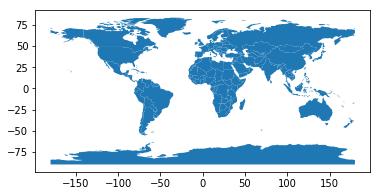

In [5]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot();

# convert geopandas data names to match JHU data

In [6]:
countries_w = world['name'].tolist()
countries_c = df_country['Country/Region'].unique().tolist()
 
conversion_dict = {'United States': 'US',
                   'Taiwan': 'Taiwan*',
                   'Czech Rep.':'Czechia',
                   'Korea':'Korea, South',
                   'Dem. Rep. Korea': 'Korea, North',
                  'Dominican Rep.':'Dominican Republic' } 
          
world['name'] = world['name'].map(conversion_dict).fillna(world['name'])

#### map country names between two dictionaries
# for country in countries_c:
#     if country not in countries_w:
#         print(country) 
        
# print('-----------')
# for country in countries_w:
#     if country not in countries_c:
#         print(country) 
# # dir(wp)

# data analysis to synthesise plotting variable

In [7]:
world['Cases'] = 0 
countries = world['name'].tolist()
 
dates = df_country['Date'].unique() 

for country in countries: 
    bool_country = df_country['Country/Region'] == country 
    bool_date = df_country['Date'] == dates[-1]
    bool_prior = df_country['Date'] == dates[-7] 
    if (bool_country & bool_date).sum() > 0:
        now_cases = df_country[bool_country & bool_date ]['Confirmed'].iloc[0]
        prior_cases = df_country[bool_country & bool_prior ]['Confirmed'].iloc[0]
        latest_cases = (now_cases-prior_cases)/7
    else:
        latest_cases = 0 
    
    bool_world = world['name'] == country 
#     world.loc[bool_world,'Cases'] = latest_cases  
    world.loc[bool_world,'Cases'] = np.log(latest_cases+1) 

 # plot world map

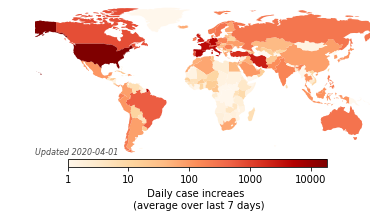

In [18]:
# fig, ax = plt.subplots(1,1 ,figsize=(15,8))
fig, ax = plt.subplots(1,1 ,figsize=half_w)

wp = world.plot(column='Cases', ax=ax, cmap='OrRd' );

wp.set_xbound(-161,161)
wp.set_ybound(-57,85) 

vmin =   world['Cases'].min()  
vmax =  world['Cases'].max() 
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))


# sm = plt.cm.ScalarMappable(cmap='OrRd' )

# cax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
# cb = fig.colorbar(sm, cax=cax )


# fake up the array of the scalar mappable. Urgh...
sm._A = []
cax = fig.add_axes([0.2, 0.2, 0.6, 0.03])
cb = fig.colorbar(sm, cax=cax, orientation='horizontal')

# wp.set_xbound(-135,-66)
# wp.set_ybound(23,49.5)   

tick_array =  [1,10,100,1000,10000, 50000 ] 
log_cases = np.log( tick_array  )  
cb.set_ticks( log_cases ) 
cb.set_ticklabels( tick_array) 
cb.set_label(' Daily case increaes  \n (average over last 7 days)')
 
ax.axis("off")

ax.annotate('Updated '+str( df_country['Date'].iloc[-1]), 
            [-161,-57], color=[.3,.3,.3], style='italic',fontsize=8)

# # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_map'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  